In [1]:
# import libraries

import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import mygene
import sklearn.preprocessing as sk
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
import random
import warnings
from random import randint
from sklearn.model_selection import StratifiedKFold

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# define directories

cell_line_dir = "/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC/"
models_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Models/GDSC_PDX_TCGA_Fourth_Strategy/"
finetuned_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Models/GDSC_PDX_TCGA_Fourth_Strategy/Fourth_Strategy_Finetuned_Models/"
DEGs_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/DNA_REPi/"
dataset_dir = "/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/"
pdx_data_dir = "/Volumes/Expansion/Thesis Work/Datasets/PDX/Expression/"
emc_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation_CNA/Predictions/GDSC_PDX_TCGA_Fourth_Strategy/"
ec_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_CNA/Predictions/GDSC_PDX_TCGA_Fourth_Strategy/"
save_results_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Predictions/GDSC_PDX_TCGA_Fourth_Strategy/"
save_figures_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Figures/GDSC_PDX_TCGA_Fourth_Strategy/"

In [3]:
# set random seeds

torch.manual_seed(42)
random.seed(42)

In [4]:
# change directory to read GDSC cell line details

os.chdir(cell_line_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC


In [5]:
# read GDSC cell line details table

GDSC_cell_line_details = pd.read_excel("GDSC_Cell_Lines_Details.xlsx", keep_default_na = False)
GDSC_cell_line_details.set_index("COSMIC identifier", inplace = True)
GDSC_cell_line_details = GDSC_cell_line_details.iloc[:-1,]
GDSC_cell_line_details.index = GDSC_cell_line_details.index.astype(str)
GDSC_cell_line_details.tail()

,Sample Name,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
COSMIC identifier,,,,,,,,,,,,
1299069,TMK-1,Y,Y,N,N,Y,digestive_system,stomach,STAD,,R,Adherent
1298218,KP-2,Y,N,Y,N,Y,pancreas,pancreas,PAAD,,D/F12,Adherent
1330932,KO52,Y,Y,N,N,N,leukemia,acute_myeloid_leukaemia,LAML,MSS/MSI-L,D/F12,NA
1331030,SC-1,Y,Y,N,N,N,lymphoma,B_cell_lymphoma,DLBC,MSS/MSI-L,R,NA
1503373,U-CH2,Y,Y,N,N,N,bone,bone_other,,MSS/MSI-L,D/F12,Adherent


In [6]:
# change directory to read GDSC expression dataset (DNA_REPi)

os.chdir(dataset_dir + "/exprs/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs


In [7]:
# read GDSC expression dataset (DNA_REPi)
# remove samples with shared cancer types from training dataset

GDSCE = pd.read_csv("GDSC_exprs.z.DNA_REPi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCE = pd.DataFrame.transpose(GDSCE)
GDSCE = pd.merge(GDSC_cell_line_details,
                 GDSCE,
                 left_index=True,
                 right_index=True)
filter = (GDSCE["GDSC\nTissue descriptor 1"] != "pancreas") & \
         (GDSCE["Cancer Type\n(matching TCGA label)"] != "PAAD") & \
         (GDSCE["Cancer Type\n(matching TCGA label)"] != "SARC") & \
         (GDSCE["Cancer Type\n(matching TCGA label)"] != "LIHC") & \
         (GDSCE["Cancer Type\n(matching TCGA label)"] != "PCPG") & \
         (GDSCE["Cancer Type\n(matching TCGA label)"] != "LUSC")
GDSCE = GDSCE.loc[filter, ]
GDSCE.drop(GDSC_cell_line_details.columns, axis=1, inplace=True)
GDSCE.index = GDSCE.index.astype(int)

GDSCE.head(3)

,1,2,9,10,12,13,14,15,16,18,...,107984199,107984208,107984325,107984411,107984648,107984889,107984989,107986313,107986782,107986810
906794,-0.523146241125996,-0.4774107580335559,1.1792180707204845,-0.1950133103016388,0.2086331356678636,0.1512743407965193,-1.0570300318558898,0.1189857462468134,-1.60237161712403,0.0522097313574845,...,0.4777943283680773,1.7440832645129538,-0.1411845263288239,1.550275627132598,1.7625075247186934,-0.9885319787599142,-1.398962216984746,-1.1477981243123072,0.2309989847175704,0.1184597758225788
753531,-0.4224302754300224,-0.3242516223071998,-0.3208981588446875,-0.4397392179491251,3.025286158155485,-0.24438999503986,0.7515936357204973,0.0632614716673226,1.1869816204036372,0.910750698661622,...,0.5061734764924927,-1.0342661397324897,-0.4760165332952215,0.4559917131361604,-0.2809661852015279,0.7118421818299816,-0.346615229870122,-1.470020745651282,0.0534664475662629,-1.0214126092212672
753532,0.38120783287858,-0.216246760163162,-1.3542414608934643,-0.0288553253901928,-0.210475976908014,-0.2095800353031544,-0.6041666360277236,-0.3005598678634803,-1.0678335183424454,-0.3855263679950399,...,2.138001331301404,0.4656565668245515,-0.6052206632622278,2.411447606433391,0.2137155086353199,-1.1485572785697182,0.6297279321839303,-0.7263920504862745,0.5305975336134361,0.0576046675547845


In [8]:
# change directory to read GDSC mutation dataset (DNA_REPi)

os.chdir(dataset_dir + "/mutations/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations


In [9]:
# read GDSC mutation dataset (DNA_REPi)
# remove samples with shared cancer types from training dataset

GDSCM = pd.read_csv("GDSC_mutations.DNA_REPi.tsv",
                    sep="\t", index_col=0, decimal=".")
GDSCM = pd.DataFrame.transpose(GDSCM)
GDSCM = GDSCM.loc[:, ~GDSCM.columns.duplicated()]
GDSCM = pd.merge(GDSC_cell_line_details,
                 GDSCM,
                 left_index=True,
                 right_index=True)
filter = (GDSCM["GDSC\nTissue descriptor 1"] != "pancreas") & \
         (GDSCM["Cancer Type\n(matching TCGA label)"] != "PAAD") & \
         (GDSCM["Cancer Type\n(matching TCGA label)"] != "SARC") & \
         (GDSCM["Cancer Type\n(matching TCGA label)"] != "LIHC") & \
         (GDSCM["Cancer Type\n(matching TCGA label)"] != "PCPG") & \
         (GDSCM["Cancer Type\n(matching TCGA label)"] != "LUSC")
GDSCM = GDSCM.loc[filter, ]
GDSCM.drop(GDSC_cell_line_details.columns, axis=1, inplace=True)
GDSCM.index = GDSCM.index.astype(int)

GDSCM.head()

,143872,728577,2,2050,10243,79365,256006,4609,118788,113675,...,26517,28972,53917,283507,514,339210,64981,7335,5739,83442
906794,-0.05,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
753531,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
753532,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
753535,0.00,0.0,0.0,0.0,0.0,0.0,-0.05,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1290724,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# change directory to read GDSC response dataset (DNA_REPi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [11]:
# read GDSC response dataset (DNA_REPi)
# remove samples with shared cancer types from training dataset

GDSCR = pd.read_csv("GDSC_response.DNA_REPi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])
GDSCR = pd.merge(GDSC_cell_line_details,
                 GDSCR,
                 left_index=True,
                 right_index=True)
filter = (GDSCR["GDSC\nTissue descriptor 1"] != "pancreas") & \
         (GDSCR["Cancer Type\n(matching TCGA label)"] != "PAAD") & \
         (GDSCR["Cancer Type\n(matching TCGA label)"] != "SARC") & \
         (GDSCR["Cancer Type\n(matching TCGA label)"] != "LIHC") & \
         (GDSCR["Cancer Type\n(matching TCGA label)"] != "PCPG") & \
         (GDSCR["Cancer Type\n(matching TCGA label)"] != "LUSC")
GDSCR = GDSCR.loc[filter, ]
GDSCR.drop(GDSC_cell_line_details.columns, axis=1, inplace=True)
GDSCR = GDSCR.loc[GDSCR["drug"] != "Gemcitabine", ]
GDSCR.index = GDSCR.index.astype(int)

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
COSMIC identifier,,,,,,
906794,0,3.25484543425934,Pyrimethamine,1,1,1
906794,0,-3.08563930086988,Doxorubicin,1,1,1
906794,1,-2.64209579180854,Etoposide,1,1,1
906794,0,-1.0950578547037,Mitomycin C,1,1,1
906794,0,4.49441980142194,5-Fluorouracil,1,1,1


In [12]:
# print count of cell lines for each drug (DNA_REPi)

GDSCR["drug"].value_counts()

drug
Etoposide         725
SN-38             721
Mitomycin C       717
Doxorubicin       716
5-Fluorouracil    714
Bleomycin         709
Temozolomide      706
Cisplatin         690
Methotrexate      690
Camptothecin      689
Cytarabine        687
Pyrimethamine     368
Name: count, dtype: int64

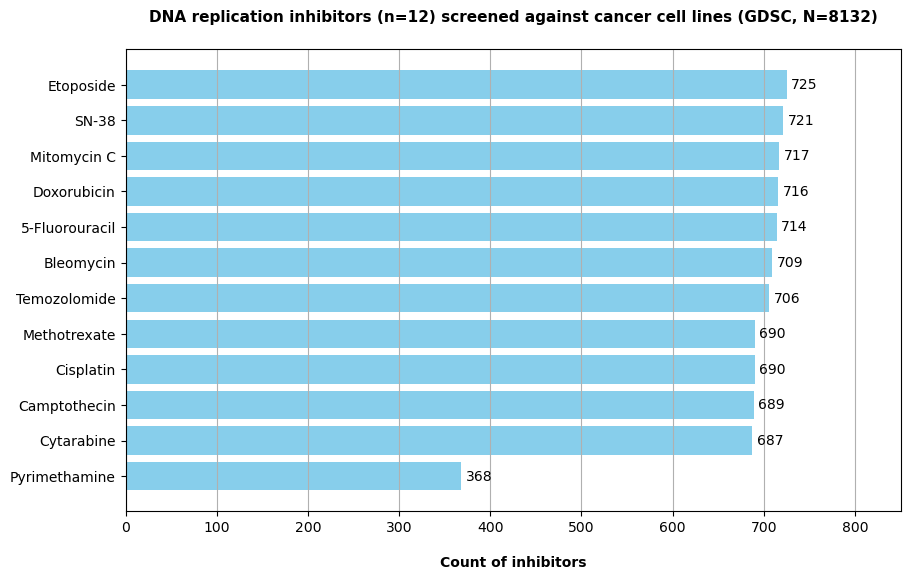

In [13]:
# plot DNA replication inhibitors with their counts

gdsc_drugs = dict(GDSCR["drug"].value_counts())
gdsc_drugs = dict(sorted(gdsc_drugs.items(), key=lambda item: item[1], reverse=False))
drug_names = list(gdsc_drugs.keys())
drug_values = list(gdsc_drugs.values())

plt.figure(figsize=(10, 6))
bars = plt.barh(drug_names, drug_values, color='skyblue')

for bar, value in zip(bars, drug_values):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')
    
bars = []

for name, value in zip(drug_names, drug_values):
    if name == "Gemcitabine":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))
plt.xlabel('Count of inhibitors', fontweight='bold', labelpad=15)
plt.title(f'DNA replication inhibitors (n={len(drug_names)}) screened against cancer cell lines (GDSC, N={sum(drug_values)})',
          fontweight='bold',
          fontsize=11,
          pad=20)
plt.xlim(0, 850)  
plt.grid(axis='x')
os.makedirs(save_figures_to, exist_ok = True)
plt.savefig(save_figures_to + 'DNA Replication Inhibitors with Their Counts (GDSC, Gemcitabine).png', format='png', bbox_inches='tight')

plt.show()

In [14]:
# change directory to read PDX and TCGA expression datasets homogenized with GDSC expression dataset (Gemcitabine)

os.chdir(dataset_dir + "/exprs_homogenized/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs_homogenized


In [15]:
# read PDX expression dataset homogenized with GDSC expression dataset (Gemcitabine)

PDXEgemcitabine = pd.read_csv("PDX_exprs.Gemcitabine.eb_with.GDSC_exprs.Gemcitabine.tsv",
                   sep = "\t", index_col=0, decimal = ",")
PDXEgemcitabine = pd.DataFrame.transpose(PDXEgemcitabine)
PDXEgemcitabine.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100507206,100507254,100507436,100507472,100526773,100527978,100532746,100820829,102724473,105375355
X-1199,4.01417756220044,3.55811958088587,6.83900390800765,4.38877376417435,1.50666127948843,5.02771257808434,8.43955592164473,2.85208997496268,9.00048066769525,5.52248167850218,...,2.83437923324963,3.18066968142204,6.86894950827138,3.09303561080421,3.06056009765469,3.25550719551845,2.66209753115624,4.89535625008263,0,2.53286170515559
X-1289,3.81163538029984,3.55811958088587,7.32657832557435,4.60329219527869,2.70668525625435,3.94530321859601,8.38639293838613,3.16570624417349,8.80528687662163,4.02249343941382,...,2.78756471299352,3.18066968142204,6.45652489684015,3.09303561080421,3.06056009765469,2.55755763454488,2.66209753115624,4.66362817768075,0,2.92817140721819
X-1317,6.56141894155303,9.93900865308036,5.9645748758066,2.89206965997821,4.24925937434505,2.43002821482342,8.19585380485642,3.24884065836222,9.13531900723866,3.39900580748116,...,2.84342078648607,4.76280820040358,6.724116861893,3.09303561080421,3.06056009765469,2.55755763454488,4.01252295145878,3.28462638352963,0,4.63700409301447


In [16]:
# read TCGA expression dataset homogenized with GDSC expression dataset (Gemcitabine)

TCGAEgemcitabine = pd.read_csv("TCGA_exprs.Gemcitabine.eb_with.GDSC_exprs.Gemcitabine.tsv",
                   sep = "\t", index_col=0, decimal = ",")
TCGAEgemcitabine = pd.DataFrame.transpose(TCGAEgemcitabine)
TCGAEgemcitabine.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100188893,100190940,100190949,100191040,100192386,100268168,100271715,100287718,100288778,100289635
TCGA-2L-AAQA-01A,3.98033768533371,2.62820652008909,7.03249429468481,3.08514834183615,3.34557990074588,3.78552975984518,8.73764964752829,2.48671779353536,8.21923206815042,3.76684655565602,...,10.0875725194276,2.81337967290836,3.51332685491118,3.98785715416424,3.07567558045391,2.56126348424232,2.63693987323012,2.83133300992887,5.13739151604047,4.69382514336529
TCGA-2L-AAQE-01A,4.68614471637408,3.25092419132046,5.75542155466148,2.79866479035723,1.96329083991897,3.43063349827168,8.80671304478463,2.62779485919227,8.54483025692787,3.81532940417382,...,8.87561409312678,2.81337967290836,2.78991865702044,3.30688425304558,3.45865630140412,2.53490145426966,2.74899279856495,2.83133300992887,4.61757632178081,4.2235154535305
TCGA-2L-AAQI-01A,3.71023111103364,3.88843437623036,5.77580575110606,3.10749843796475,5.98690471000489,3.75736553725429,8.4255369043372,2.48671779353536,9.21052968908206,3.97685914269242,...,9.48642956588486,2.84555917176674,2.78991865702044,3.48989111572046,2.79620231354257,2.49624245190844,2.630937590025,2.83133300992887,4.38859435268046,3.64555981820771


In [17]:
# change directory to read PDX mutation dataset (Gemcitabine)

os.chdir(dataset_dir + "mutations")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations'

In [18]:
# read PDX mutation dataset (Gemcitabine)

PDXMgemcitabine = pd.read_csv("PDX_mutations.Gemcitabine.tsv",
                        sep="\t", index_col=0, decimal=",")
PDXMgemcitabine.drop_duplicates(keep='last')
PDXMgemcitabine = pd.DataFrame.transpose(PDXMgemcitabine)
PDXMgemcitabine = PDXMgemcitabine.loc[:, ~PDXMgemcitabine.columns.duplicated()]

PDXMgemcitabine.head(3)

ENTREZID,3075.0,171017.0,2058.0,79890.0,7701.0,3104.0,4642.0,9778.0,100132406.0,23607.0,...,253738.0,154807.0,79140.0,6307.0,6352.0,56005.0,115650.0,64946.0,5777.0,253639.0
X-1199,0.0,0.0,0.0,-0.05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1289,0.0,-0.05,0.0,-0.05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1317,0.0,-0.05,0.0,-0.05,0.0,0.0,0.0,0.0,-0.05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# read TCGA mutation dataset (Gemcitabine)

TCGAMgemcitabine = pd.read_csv("TCGA_mutations.Gemcitabine.tsv",
                        sep="\t", index_col=0, decimal=",")
TCGAMgemcitabine.drop_duplicates(keep='last')
TCGAMgemcitabine = pd.DataFrame.transpose(TCGAMgemcitabine)
TCGAMgemcitabine = TCGAMgemcitabine.loc[:, ~TCGAMgemcitabine.columns.duplicated()]

TCGAMgemcitabine.head(3)

,10946,23301,26470,340075,2059,26286,2034,348980,406,653240,...,6176,91948,9403,113402,8637,389124,277,83460,51021,1052
TCGA-2L-AAQA-01A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.1,0.0,-0.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-2L-AAQE-01A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-2L-AAQI-01A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# variance threshold for GDSC expression dataset (DNA_REPi)

selector = VarianceThreshold(0.05)
selector.fit_transform(GDSCE)
GDSCE = GDSCE[GDSCE.columns[selector.get_support(indices=True)]]

In [21]:
# fill NA values and binarize GDSC mutation dataset (DNA_REPi)

GDSCM = GDSCM.fillna(0)
GDSCM[GDSCM != 0.0] = 1

In [22]:
# select shared genes between GDSC, PDX, and TCGA expression and mutation datasets 

ls = GDSCE.columns.intersection(GDSCM.columns)
ls = ls.intersection(PDXEgemcitabine.columns)
ls = ls.intersection(PDXMgemcitabine.columns)
ls = ls.intersection(TCGAEgemcitabine.columns)
ls = ls.intersection(TCGAMgemcitabine.columns)

ls = pd.unique(ls)

print(f"GDSC, PDX & TCGA # of common genes: {ls.shape[0]}")

GDSC, PDX & TCGA # of common genes: 13831


In [23]:
# select shared samples between GDSC expression, mutation, and response datasets (DNA_REPi)

ls2 = GDSCE.index.intersection(GDSCM.index)
ls2 = ls2.intersection(GDSCR.index)

print(f"GDSC # of common cell lines: {ls2.shape[0]}")

GDSC # of common cell lines: 751


In [24]:
# subset shared genes and samples in GDSC expression, mutation, and response datasets

GDSCE = GDSCE.loc[ls2, ls]
GDSCM = GDSCM.loc[ls2, ls]
GDSCR = GDSCR.loc[ls2, :]

print(f"GDSC # of common samples and genes (Expression): {GDSCE.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCM.shape}")
print(f"GDSC # of samples (Response): {GDSCR.shape[0]}")

GDSC # of common samples and genes (Expression): (751, 13831)
GDSC # of common samples and genes (Mutation): (751, 13831)
GDSC # of samples (Response): 8132


In [25]:
# select shared samples between PDX expression and mutation datasets (Gemcitabine) 

ls3 = PDXEgemcitabine.index.intersection(PDXMgemcitabine.index)

print(f"PDX # of common samples (Gemcitabine): {ls3.shape[0]}")

PDX # of common samples (Gemcitabine): 25


In [26]:
# select shared samples between TCGA expression and mutation datasets (Gemcitabine) 

ls4 = TCGAEgemcitabine.index.intersection(TCGAMgemcitabine.index)

print(f"TCGA # of common samples (Gemcitabine): {ls4.shape[0]}")

TCGA # of common samples (Gemcitabine): 55


In [27]:
# select shared genes and samples between PDX and TCGA expression and mutation datasets (Gemcitabine)

PDXEgemcitabine = PDXEgemcitabine.loc[ls3, ls]
PDXMgemcitabine = PDXMgemcitabine.loc[ls3, ls]

TCGAEgemcitabine = TCGAEgemcitabine.loc[ls4, ls]
TCGAMgemcitabine = TCGAMgemcitabine.loc[ls4, ls]

print(f"PDX # of common samples and genes for Expression (Gemcitabine): {PDXEgemcitabine.shape}")
print(f"PDX # of common samples and genes for Mutation (Gemcitabine): {PDXMgemcitabine.shape}\n")

print(f"TCGA # of common samples and genes for Expression (Gemcitabine): {TCGAEgemcitabine.shape}")
print(f"TCGA # of common samples and genes for Mutation (Gemcitabine): {TCGAMgemcitabine.shape}")

PDX # of common samples and genes for Expression (Gemcitabine): (25, 13831)
PDX # of common samples and genes for Mutation (Gemcitabine): (25, 13831)

TCGA # of common samples and genes for Expression (Gemcitabine): (55, 13831)
TCGA # of common samples and genes for Mutation (Gemcitabine): (55, 13831)


In [28]:
# change directory to read DEGs (DNA_REPi)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/DNA_REPi


In [29]:
# read DEGs (DNA_REPi)

DEGs_filtered_data = pd.read_excel("DNA_REPi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                    sheet_name = "Common DEGs")
print(f"There are {DEGs_filtered_data.shape[0]} DEGs (p-adjusted < 0.05 and |logFC| > 1) among DNA replication inhibitors\n")

DEGs_filtered_data.head()

There are 858 DEGs (p-adjusted < 0.05 and |logFC| > 1) among DNA replication inhibitors



,Gene Symbol,Frequency
0,SLFN11,9
1,NCKAP1L,8
2,SDC4,7
3,KRT18,7
4,S100A14,7


In [30]:
# get gene symbol from mygene database

mg = mygene.MyGeneInfo()
DEGs_entrez_id = mg.querymany(DEGs_filtered_data["Gene Symbol"], 
                              species="human", 
                              scopes = "symbol",
                              field = "entrezgene",
                              as_dataframe=True)["entrezgene"]
DEGs_entrez_id.dropna(inplace=True)

DEGs_entrez_id.shape[0]

1 input query terms found dup hits:	[('CLECL1P', 2)]


858

In [31]:
# assign GDSC datasets to new variables

exprs_z = GDSCE
mut = GDSCM
responses = GDSCR

In [32]:
# GDSC response dataset

responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
906794,0,3.25484543425934,Pyrimethamine,1,1,1
906794,0,-3.08563930086988,Doxorubicin,1,1,1
906794,1,-2.64209579180854,Etoposide,1,1,1


In [33]:
# list drug names in GDSC response dataset

drugs = set(responses["drug"].values)
drugs

{'5-Fluorouracil',
 'Bleomycin',
 'Camptothecin',
 'Cisplatin',
 'Cytarabine',
 'Doxorubicin',
 'Etoposide',
 'Methotrexate',
 'Mitomycin C',
 'Pyrimethamine',
 'SN-38',
 'Temozolomide'}

In [34]:
# convert Entrez gene IDs to string

GDSCE.index = GDSCE.index.astype(str)
GDSCM.index = GDSCM.index.astype(str)
responses.index = responses.index.astype(str)

In [35]:
# merge GDSC cell line details with response dataset

dat = pd.merge(GDSC_cell_line_details,
         responses,
         left_index = True, 
         right_index=True,
         how = "inner")

dat["GDSC\nTissue descriptor 1"].value_counts()
#dat.head()

GDSC\nTissue descriptor 1
urogenital_system    850
lung_NSCLC           817
leukemia             765
lymphoma             710
aero_dig_tract       665
nervous_system       560
lung_SCLC            523
skin                 513
breast               481
large_intestine      412
bone                 387
neuroblastoma        307
digestive_system     289
kidney               210
soft_tissue          175
myeloma              169
lung                 159
thyroid              140
Name: count, dtype: int64

In [36]:
# get tissue descriptors

dat["GDSC\nTissue\ndescriptor 2"].value_counts().head()

GDSC\nTissue\ndescriptor 2
lung_NSCLC_adenocarcinoma    586
lung_small_cell_carcinoma    523
glioma                       515
breast                       481
melanoma                     478
Name: count, dtype: int64

In [37]:
# assign tissue descriptors to variable

gdsc_tissue_counts = dat["GDSC\nTissue descriptor 1"].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_names

['urogenital_system',
 'lung_NSCLC',
 'leukemia',
 'lymphoma',
 'aero_dig_tract',
 'nervous_system',
 'lung_SCLC',
 'skin',
 'breast',
 'large_intestine',
 'bone',
 'neuroblastoma',
 'digestive_system',
 'kidney',
 'soft_tissue',
 'myeloma',
 'lung',
 'thyroid']

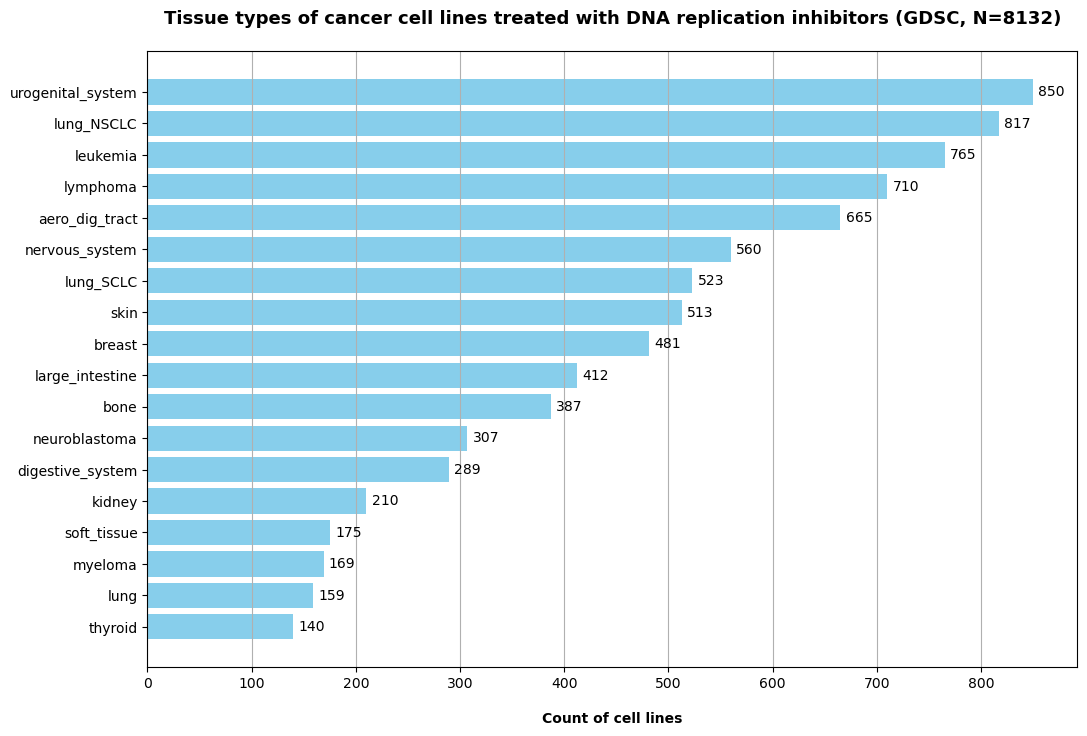

In [38]:
# plot tissue types of cancer cell lines treated with EGFR signaling inhibitors

gdsc_tissue_counts = dat["GDSC\nTissue descriptor 1"].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_counts = list(gdsc_tissue_counts)

plt.figure(figsize=(12, 8))
plt.barh(tissue_names, tissue_counts, color='skyblue')
plt.xlabel('Count of cell lines', fontweight='bold', labelpad = 15)
plt.title(f'Tissue types of cancer cell lines treated with DNA replication inhibitors (GDSC, N={sum(tissue_counts)})',
           fontweight='bold',
           fontsize=13,
           pad=20)
plt.gca().invert_yaxis() 
plt.grid(axis='x')

bars = plt.barh(tissue_names, tissue_counts, color='skyblue')

for bar, value in zip(bars, tissue_counts):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')

bars = []

for name, value in zip(tissue_names, tissue_counts):
    if name == "pancreas":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))

plt.savefig(save_figures_to + 'Tissue types of cancer cell lines treated with DNA replication inhibitors (GDSC).png', format='png', bbox_inches='tight')

plt.show()

In [39]:
# list count of cell lines as to tissues treated with gemcitabine

tissues_drugs = dat[["GDSC\nTissue descriptor 1","GDSC\nTissue\ndescriptor 2","drug"]]

filter = (tissues_drugs["drug"] == "Gemcitabine")
tissues_drug = tissues_drugs.loc[filter,"GDSC\nTissue\ndescriptor 2"].value_counts()

tissues_drug.head()

Series([], Name: count, dtype: int64)

In [40]:
# list count of cell lines as to tissues treated with gemcitabine

filter = (dat["drug"] == "Gemcitabine")
dat.loc[filter,"GDSC\nTissue descriptor 1"].value_counts()

Series([], Name: count, dtype: int64)

In [41]:
# filter GDSC expression and mutation datasets (DNA_REPi) as to drugs
# subset selected DEGs

expression_zscores = []
mutations = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    m = mut.loc[samples, :]
    expression_zscores.append(e_z)
    mutations.append(m)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCMv2 = pd.concat(mutations, axis=0)
GDSCRv2 = responses

ls5 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls6 = GDSCEv2.index.intersection(GDSCMv2.index)

GDSCEv2 = GDSCEv2.loc[ls6, ls5]
GDSCMv2 = GDSCMv2.loc[ls6, ls5]
GDSCRv2 = GDSCRv2.loc[ls6, :]

PDXEgemcitabine = PDXEgemcitabine.loc[:,ls5]
PDXMgemcitabine = PDXMgemcitabine.loc[:,ls5]
TCGAEgemcitabine = TCGAEgemcitabine.loc[:,ls5]
TCGAMgemcitabine = TCGAMgemcitabine.loc[:,ls5]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCMv2.shape}")
print(f"GDSC # of common samples (Response): {GDSCRv2.shape[0]}\n")

print(f"PDX # of common samples and genes for Gemcitabine (Expression): {PDXEgemcitabine.shape}")
print(f"PDX # of common samples and genes for Gemcitabine (Mutation): {PDXMgemcitabine.shape}\n")

print(f"TCGA # of common samples and genes for Gemcitabine (Expression): {TCGAEgemcitabine.shape}")
print(f"TCGA # of common samples and genes for Gemcitabine (Mutation): {TCGAMgemcitabine.shape}")

GDSC # of common samples and genes (Expression): (8132, 710)
GDSC # of common samples and genes (Mutation): (8132, 710)
GDSC # of common samples (Response): 8132

PDX # of common samples and genes for Gemcitabine (Expression): (25, 710)
PDX # of common samples and genes for Gemcitabine (Mutation): (25, 710)

TCGA # of common samples and genes for Gemcitabine (Expression): (55, 710)
TCGA # of common samples and genes for Gemcitabine (Mutation): (55, 710)


In [42]:
# GDSC response values

Y = GDSCRv2['response'].values
print(Y)

[0 0 1 ... 0 0 0]


In [43]:
# change directory to read PDX and TCGA response datasets (Gemcitabine)

os.chdir(dataset_dir + "response")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response'

In [44]:
# read PDX response dataset (Gemcitabine)

PDXRgemcitabine = pd.read_csv("PDX_response.Gemcitabine.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
PDXRgemcitabine.dropna(inplace=True)
PDXRgemcitabine.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
PDXRgemcitabine["response"] = PDXRgemcitabine.loc[:, "response"].apply(lambda x: d[x])
Ytsgemcitabine_pdx = PDXRgemcitabine["response"].values    

print(f"There are {Ytsgemcitabine_pdx.shape[0]} samples with response data in the PDX (Gemcitabine)\n")
Ytsgemcitabine_pdx

There are 25 samples with response data in the PDX (Gemcitabine)



array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1])

In [45]:
# read PDX dataset to select cohorts (Gemcitabine)

pdx_cohort = pd.read_excel(pdx_data_dir + "/nm.3954-S2.xlsx",
                              "PCT raw data")
pdx_cohort = pdx_cohort.loc[pdx_cohort["Treatment"] == "gemcitabine-50mpk",]
pdx_cohort = pdx_cohort.loc[:,["Model","Tumor Type"]]
pdx_cohort = pdx_cohort.drop_duplicates()
pdx_cohort.set_index("Model", inplace = True) 
pdx_cohort.head()

,Tumor Type
Model,
X-0991,PDAC
X-1199,PDAC
X-1289,PDAC
X-1317,PDAC
X-1362,PDAC


In [46]:
# merged PDX cohort table with PDX response dataset (Gemcitabine)

dat_pdx = pd.merge(pdx_cohort,
                   PDXRgemcitabine,
                   left_index = True,
                   right_index = True)
dat_pdx["Tumor Type"].value_counts()

Tumor Type
PDAC    25
Name: count, dtype: int64

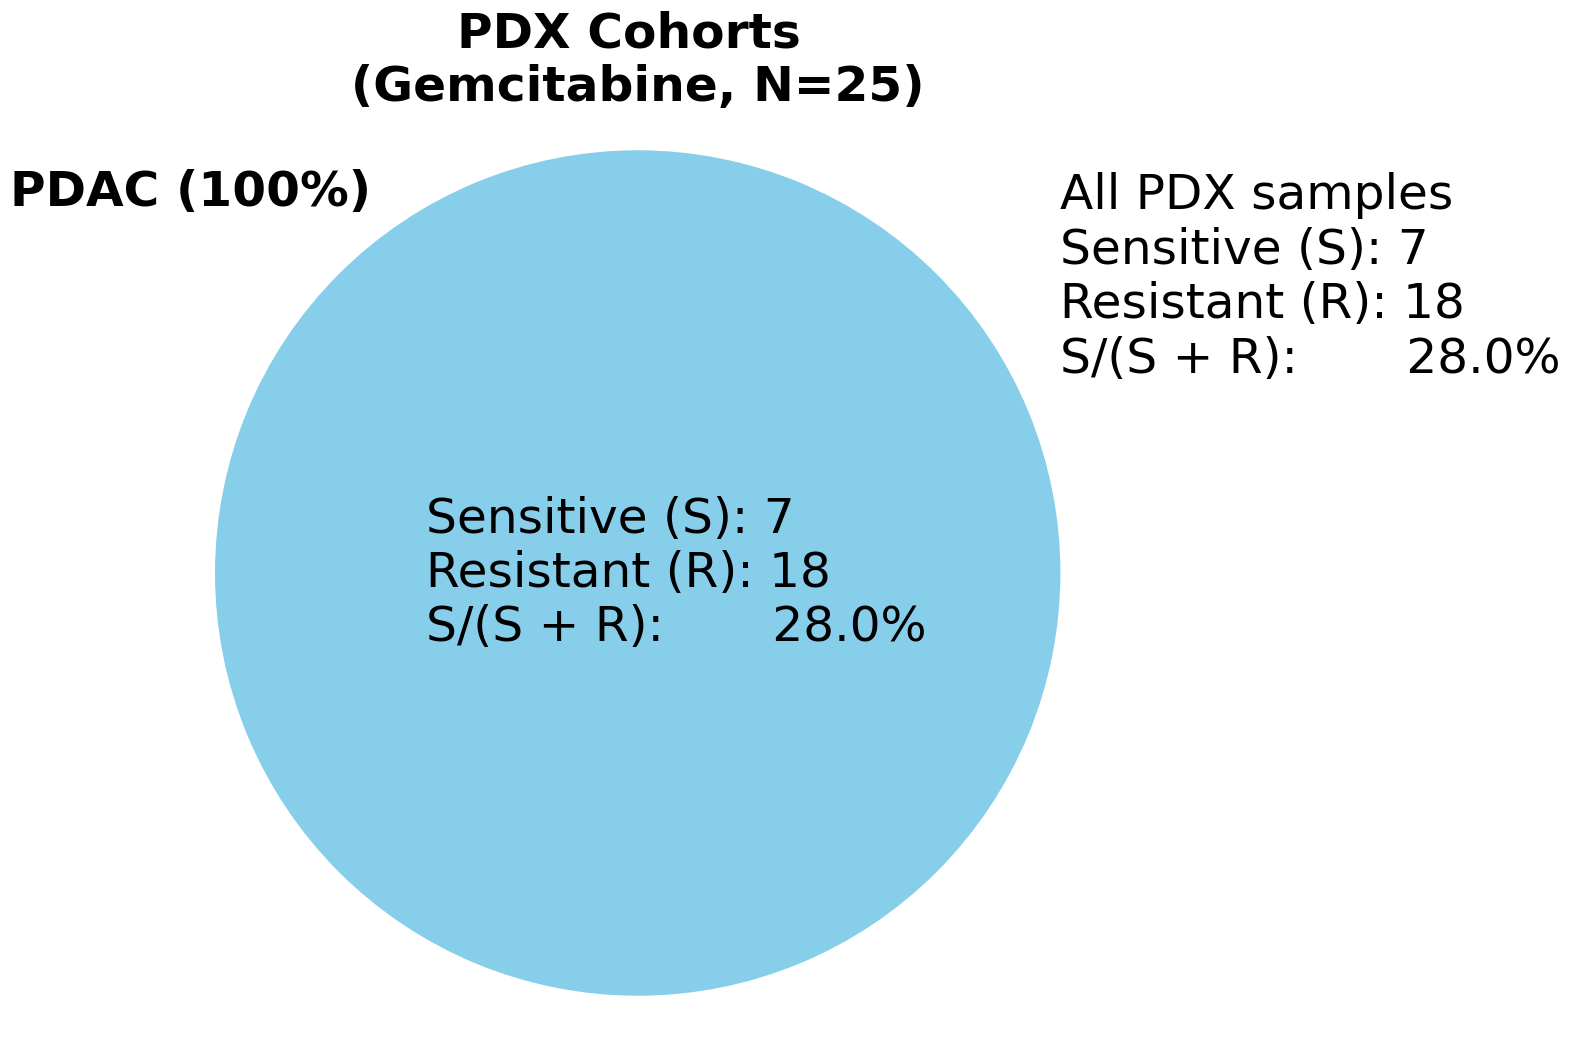

In [47]:
# plot tissue types of PDX samples

labels = list(dat_pdx["Tumor Type"].value_counts().index)
sizes = list(dat_pdx["Tumor Type"].value_counts().astype(int))
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

plt.figure(figsize=(12, 12))
plt.pie(sizes, labels=labels_with_percentages, startangle=-55, colors=['skyblue'], textprops={'fontsize': 35, 'fontweight': 'bold'})
plt.title(f'PDX Cohorts \n(Gemcitabine, N={total})', fontweight = "bold", fontsize = 35)
plt.axis('equal')  

plt.text(-0.5, 0, 
         f'Sensitive (S): {PDXRgemcitabine["response"].value_counts()[1]} \nResistant (R): {PDXRgemcitabine["response"].value_counts()[0]} \nS/(S + R):       {round(PDXRgemcitabine["response"].value_counts()[1]/(sum(PDXRgemcitabine["response"].value_counts())) * 100, 2)}%', 
         fontsize=35, 
         color='black',
         va='center')

plt.text(1, 0.7, 
         f'All PDX samples\nSensitive (S): {PDXRgemcitabine["response"].value_counts()[1]} \nResistant (R): {PDXRgemcitabine["response"].value_counts().get(0, 0)} \nS/(S + R):       {round(PDXRgemcitabine["response"].value_counts()[1]/(sum(PDXRgemcitabine["response"].value_counts())) * 100, 2)}%', 
         fontsize=35, 
         color='black',
         va='center')

plt.savefig(save_figures_to + 'Tissue types of PDX samples (Gemcitabine).png', format='png', bbox_inches='tight')

plt.show()

In [48]:
# filter PDAC cohort samples (Gemcitabine)

filter = (dat_pdx["Tumor Type"] == "PDAC")
pdx_pdac_samples = dat_pdx.loc[filter,].index
pdx_pdac_samples

Index(['X-1199', 'X-1289', 'X-1317', 'X-1362', 'X-2026', 'X-2043', 'X-2081',
       'X-2283', 'X-2339', 'X-2428', 'X-3052', 'X-3268', 'X-3782', 'X-3800',
       'X-3816', 'X-3846', 'X-3947', 'X-3990', 'X-4015', 'X-4226', 'X-4316',
       'X-4378', 'X-4649', 'X-4676', 'X-5205'],
      dtype='object')

In [49]:
# filter responses of PDAC cohort samples (Gemcitabine)

Ytsgemcitabine_pdx_pdac = PDXRgemcitabine.loc[pdx_pdac_samples,"response"].values
Ytsgemcitabine_pdx_pdac

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1])

In [50]:
# count of sensitive and resistant PDAC samples (Gemcitabine)

PDXRgemcitabine.loc[pdx_pdac_samples,"response"].value_counts()

response
0    18
1     7
Name: count, dtype: int64

In [51]:
# read TCGA response dataset (Gemcitabine)

TCGARgemcitabine = pd.read_csv("TCGA_response.Gemcitabine.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
TCGARgemcitabine.dropna(inplace=True)
TCGARgemcitabine.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
TCGARgemcitabine["response"] = TCGARgemcitabine.loc[:, "response"].apply(lambda x: d[x])
Ytsgemcitabine_tcga = TCGARgemcitabine["response"].values    

print(f"There are {Ytsgemcitabine_tcga.shape[0]} samples with response data in the TCGA (Gemcitabine)\n")
Ytsgemcitabine_tcga

There are 55 samples with response data in the TCGA (Gemcitabine)



array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0])

In [52]:
# TCGA cohort table with TCGA response dataset (Gemcitabine)

dat_tcga = TCGARgemcitabine["cohort"]

dat_tcga.value_counts()

cohort
PAAD    48
SARC     3
LIHC     2
LUSC     1
PCPG     1
Name: count, dtype: int64

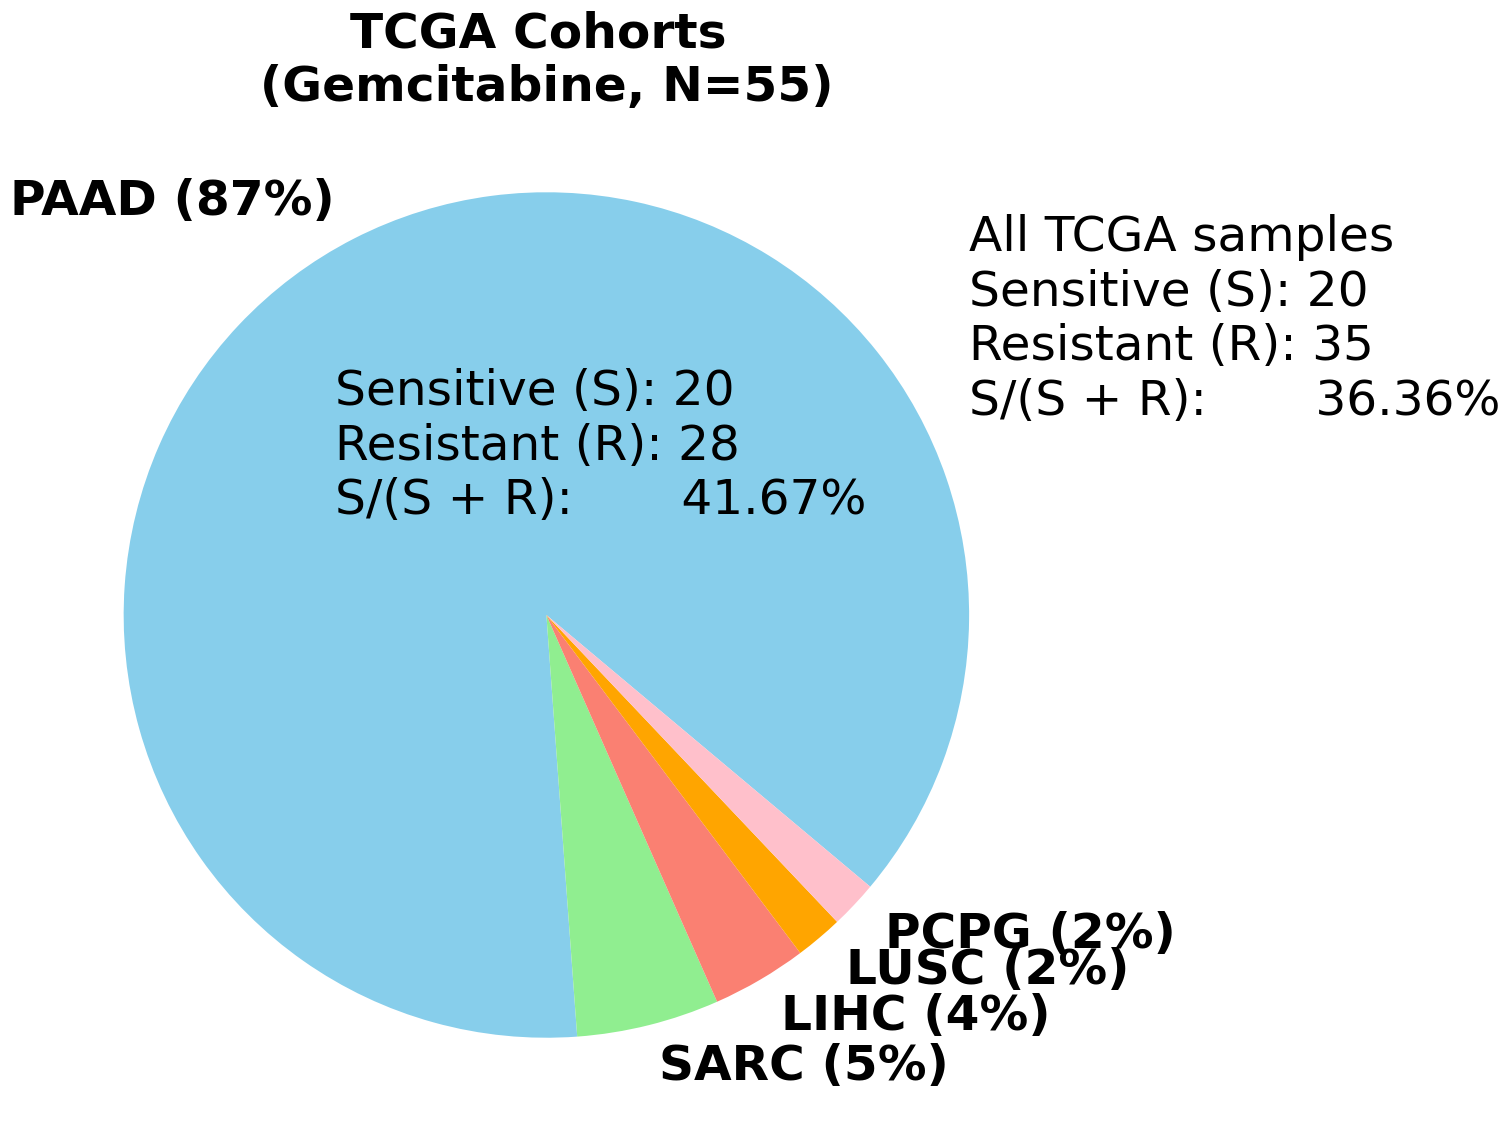

In [53]:
# plot tissue types of TCGA samples

labels = list(dat_tcga.value_counts().index)
sizes = list(dat_tcga.value_counts())
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

plt.figure(figsize=(12, 12))
plt.pie(sizes, labels=labels_with_percentages, startangle=-40, colors=['skyblue', 'lightgreen', 'salmon', 'orange', 'pink'], textprops={'fontsize': 35, 'fontweight': 'bold'})
plt.title(f'TCGA Cohorts \n(Gemcitabine, N={total})', fontweight = "bold", fontsize = 35)
plt.subplots_adjust(top=0.95) 
plt.axis('equal')  

#plt.text(0.4, -0.5, 
#         f'Sensitive (S): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "SARC","response"].value_counts().get(1,0)} \nResistant (R): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "SARC","response"].value_counts()[0]} \nS/(S + R):       {round(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "SARC","response"].value_counts().get(1,0)/(sum(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "SARC","response"].value_counts())) * 100, 2)}%', 
#         fontsize=9, 
#         color='black',
#         va='center')
#
#plt.text(0.5, -0.3, 
#         f'Sensitive (S): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "LIHC","response"].value_counts().get(1, 0)} \nResistant (R): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "LIHC","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "LIHC","response"].value_counts().get(1,0)/(sum(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "LIHC","response"].value_counts())) * 100, 2)}%', 
#         fontsize=9, 
#         color='black',
#         va='center')

plt.text(-0.5, 0.4, 
         f'Sensitive (S): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()[1]} \nResistant (R): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()[0]} \nS/(S + R):       {round(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()[1]/(sum(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts())) * 100, 2)}%', 
         fontsize=35, 
         color='black',
         va='center')

#plt.text(0.1, -0.08, 
#         f'Sensitive (S): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "LUSC","response"].value_counts().get(1,0)} \nResistant (R): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "LUSC","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "LUSC","response"].value_counts().get(1,0)/(sum(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "LUSC","response"].value_counts())) * 100, 2)}%', 
#         fontsize=9, 
#         color='black',
#         va='center')
#
#plt.text(0.6, 0, 
#         f'Sensitive (S): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PCPG","response"].value_counts().get(1,0)} \nResistant (R): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PCPG","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PCPG","response"].value_counts().get(1,0)/(sum(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PCPG","response"].value_counts())) * 100, 2)}%', 
#         fontsize=9, 
#         color='black',
#         va='center')

plt.text(1, 0.7, 
         f'All TCGA samples\nSensitive (S): {TCGARgemcitabine["response"].value_counts()[1]} \nResistant (R): {TCGARgemcitabine["response"].value_counts().get(0, 0)} \nS/(S + R):       {round(TCGARgemcitabine["response"].value_counts()[1]/(sum(TCGARgemcitabine["response"].value_counts())) * 100, 2)}%', 
         fontsize=35, 
         color='black',
         va='center')

plt.savefig(save_figures_to + 'Tissue types of TCGA samples (Gemcitabine).png', format='png', bbox_inches='tight')

plt.show()

In [54]:
# filter PAAD cohort samples (Gemcitabine)

filter = (TCGARgemcitabine["cohort"] == "PAAD")
tcga_paad_samples = dat_tcga.loc[filter,].index
tcga_paad_samples

Index(['TCGA-2L-AAQA-01A', 'TCGA-2L-AAQE-01A', 'TCGA-2L-AAQI-01A',
       'TCGA-2L-AAQJ-01A', 'TCGA-3A-A9I9-01A', 'TCGA-3A-A9IH-01A',
       'TCGA-3A-A9IX-01A', 'TCGA-3A-A9IZ-01A', 'TCGA-3A-A9J0-01A',
       'TCGA-F2-6879-01A', 'TCGA-F2-6880-01A', 'TCGA-F2-7273-01A',
       'TCGA-F2-7276-01A', 'TCGA-F2-A44G-01A', 'TCGA-F2-A44H-01A',
       'TCGA-F2-A8YN-01A', 'TCGA-FB-A5VM-01A', 'TCGA-FB-A78T-01A',
       'TCGA-FB-AAPP-01A', 'TCGA-FB-AAPY-01A', 'TCGA-FB-AAQ6-01A',
       'TCGA-H8-A6C1-01A', 'TCGA-HZ-7924-01A', 'TCGA-HZ-8317-01A',
       'TCGA-HZ-A49G-01A', 'TCGA-HZ-A49H-01A', 'TCGA-HZ-A77O-01A',
       'TCGA-HZ-A77P-01A', 'TCGA-IB-7644-01A', 'TCGA-IB-7647-01A',
       'TCGA-IB-7651-01A', 'TCGA-IB-7652-01A', 'TCGA-IB-7885-01A',
       'TCGA-IB-7889-01A', 'TCGA-IB-7891-01A', 'TCGA-IB-8127-01A',
       'TCGA-IB-A5SO-01A', 'TCGA-IB-A5SP-01A', 'TCGA-IB-A5SS-01A',
       'TCGA-IB-A6UF-01A', 'TCGA-IB-A7LX-01A', 'TCGA-IB-AAUO-01A',
       'TCGA-LB-A8F3-01A', 'TCGA-Q3-A5QY-01A', 'TCGA-RB-AA9M-0

In [55]:
# filter responses of PAAD cohort samples (Gemcitabine)

Ytsgemcitabine_tcga_paad = TCGARgemcitabine.loc[tcga_paad_samples,"response"].values
Ytsgemcitabine_tcga_paad

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0])

In [56]:
# count of sensitive and resistance _paad samples (Gemcitabine)

TCGARgemcitabine.loc[tcga_paad_samples,"response"].value_counts()

response
0    28
1    20
Name: count, dtype: int64

In [57]:
# maximum iteration

max_iter = 50

In [58]:
# use count of nodes and dropout rates found in trained pan-drug dataset

hdm1 = 16
hdm2 = 16
rate1 = 0.4
rate2 = 0.3
rate3 = 0.3

In [59]:
# load pre-trained modules and make predictions

scalerGDSC = sk.StandardScaler()
scalerGDSC.fit(GDSCEv2.values)
X_trainE = scalerGDSC.transform(GDSCEv2.values)
X_testEgemcitabine_pdx = scalerGDSC.transform(PDXEgemcitabine.values) 
X_testEgemcitabine_pdx_pdac = scalerGDSC.transform(PDXEgemcitabine.loc[pdx_pdac_samples,].values) 

X_testEgemcitabine_tcga = scalerGDSC.transform(TCGAEgemcitabine.values)    
X_testEgemcitabine_tcga_paad = scalerGDSC.transform(TCGAEgemcitabine.loc[tcga_paad_samples,].values)    

X_trainM = np.nan_to_num(GDSCMv2.values)
X_testMgemcitabine_pdx = np.nan_to_num(PDXMgemcitabine.values.astype(np.float32))
X_testMgemcitabine_pdx_pdac = np.nan_to_num(PDXMgemcitabine.loc[pdx_pdac_samples,].values.astype(np.float32))
X_testMgemcitabine_tcga = np.nan_to_num(TCGAMgemcitabine.values.astype(np.float32))
X_testMgemcitabine_tcga_paad = np.nan_to_num(TCGAMgemcitabine.loc[tcga_paad_samples,].values.astype(np.float32))

TX_testEgemcitabine_pdx = torch.FloatTensor(X_testEgemcitabine_pdx)
TX_testEgemcitabine_pdx_pdac = torch.FloatTensor(X_testEgemcitabine_pdx_pdac)

TX_testMgemcitabine_pdx = torch.FloatTensor(X_testMgemcitabine_pdx.astype(np.float32))
TX_testMgemcitabine_pdx_pdac = torch.FloatTensor(X_testMgemcitabine_pdx_pdac.astype(np.float32))

ty_testEgemcitabine_pdx = torch.FloatTensor(Ytsgemcitabine_pdx.astype(int))
ty_testEgemcitabine_pdx_pdac = torch.FloatTensor(Ytsgemcitabine_pdx_pdac.astype(int))

TX_testEgemcitabine_tcga = torch.FloatTensor(X_testEgemcitabine_tcga)
TX_testEgemcitabine_tcga_paad = torch.FloatTensor(X_testEgemcitabine_tcga_paad)

TX_testMgemcitabine_tcga = torch.FloatTensor(X_testMgemcitabine_tcga.astype(np.float32))
TX_testMgemcitabine_tcga_paad = torch.FloatTensor(X_testMgemcitabine_tcga_paad.astype(np.float32))

ty_testEgemcitabine_tcga = torch.FloatTensor(Ytsgemcitabine_tcga.astype(int))
ty_testEgemcitabine_tcga_paad = torch.FloatTensor(Ytsgemcitabine_tcga_paad.astype(int))

n_sampE, IE_dim = X_trainE.shape
n_sampM, IM_dim = X_trainM.shape

h_dim1 = hdm1
h_dim2 = hdm2
Z_in = h_dim1 + h_dim2

class AEE(nn.Module):
    def __init__(self):
        super(AEE, self).__init__()
        self.EnE = torch.nn.Sequential(
            nn.Linear(IE_dim, h_dim1),
            nn.BatchNorm1d(h_dim1),
            nn.ReLU(),
            nn.Dropout(rate1))
    def forward(self, x):
        output = self.EnE(x)
        return output  


class AEM(nn.Module):
    def __init__(self):
        super(AEM, self).__init__()
        self.EnM = torch.nn.Sequential(
            nn.Linear(IM_dim, h_dim2),
            nn.BatchNorm1d(h_dim2),
            nn.ReLU(),
            nn.Dropout(rate2))
    def forward(self, x):
        output = self.EnM(x)
        return output       
        
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.FC = torch.nn.Sequential(
            nn.Linear(Z_in, 1),
            nn.Dropout(rate3),
            nn.Sigmoid())
    def forward(self, x):
        return self.FC(x)

torch.cuda.manual_seed_all(42)

AutoencoderE = torch.load(models_dir + "Exprs_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Fourth_Strategy.pt")
AutoencoderM = torch.load(models_dir + "Mut_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Fourth_Strategy.pt")

Clas = torch.load(models_dir + "Class_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Fourth_Strategy.pt")

AutoencoderE.eval()
AutoencoderM.eval()
Clas.eval()

ZEX = AutoencoderE(torch.FloatTensor(X_trainE))
ZMX = AutoencoderM(torch.FloatTensor(X_trainM))
ZTX = torch.cat((ZEX, ZMX), 1)
ZTX = F.normalize(ZTX, p=2, dim=0)
PredX = Clas(ZTX)
AUCT = roc_auc_score(Y, PredX.detach().numpy())
AUCTaucpr = average_precision_score(Y, PredX.detach().numpy())

ZETgemcitabine_pdx = AutoencoderE(TX_testEgemcitabine_pdx)
ZMTgemcitabine_pdx = AutoencoderM(TX_testMgemcitabine_pdx)
ZTTgemcitabine_pdx = torch.cat((ZETgemcitabine_pdx, ZMTgemcitabine_pdx), 1)
ZTTgemcitabine_pdx = F.normalize(ZTTgemcitabine_pdx, p=2, dim=0)
PredTgemcitabine_pdx = Clas(ZTTgemcitabine_pdx)
AUCTgemcitabine_pdx = roc_auc_score(Ytsgemcitabine_pdx.astype(int), PredTgemcitabine_pdx.detach().numpy())
AUCTgemcitabine_pdx_aucpr = average_precision_score(Ytsgemcitabine_pdx.astype(int), PredTgemcitabine_pdx.detach().numpy())

ZETgemcitabine_pdx_pdac = AutoencoderE(TX_testEgemcitabine_pdx_pdac)
ZMTgemcitabine_pdx_pdac = AutoencoderM(TX_testMgemcitabine_pdx_pdac)
ZTTgemcitabine_pdx_pdac = torch.cat((ZETgemcitabine_pdx_pdac, ZMTgemcitabine_pdx_pdac), 1)
ZTTgemcitabine_pdx_pdac = F.normalize(ZTTgemcitabine_pdx_pdac, p=2, dim=0)
PredTgemcitabine_pdx_pdac = Clas(ZTTgemcitabine_pdx_pdac)
AUCTgemcitabine_pdx_pdac = roc_auc_score(Ytsgemcitabine_pdx_pdac.astype(int), PredTgemcitabine_pdx_pdac.detach().numpy())
AUCTgemcitabine_pdx_pdac_aucpr = average_precision_score(Ytsgemcitabine_pdx_pdac.astype(int), PredTgemcitabine_pdx_pdac.detach().numpy())

ZETgemcitabine_tcga = AutoencoderE(TX_testEgemcitabine_tcga)
ZMTgemcitabine_tcga = AutoencoderM(TX_testMgemcitabine_tcga)
ZTTgemcitabine_tcga = torch.cat((ZETgemcitabine_tcga, ZMTgemcitabine_tcga), 1)
ZTTgemcitabine_tcga = F.normalize(ZTTgemcitabine_tcga, p=2, dim=0)
PredTgemcitabine_tcga = Clas(ZTTgemcitabine_tcga)
AUCTgemcitabine_tcga = roc_auc_score(Ytsgemcitabine_tcga.astype(int), PredTgemcitabine_tcga.detach().numpy())
AUCTgemcitabine_tcga_aucpr = average_precision_score(Ytsgemcitabine_tcga.astype(int), PredTgemcitabine_tcga.detach().numpy())

ZETgemcitabine_tcga_paad = AutoencoderE(TX_testEgemcitabine_tcga_paad)
ZMTgemcitabine_tcga_paad = AutoencoderM(TX_testMgemcitabine_tcga_paad)
ZTTgemcitabine_tcga_paad = torch.cat((ZETgemcitabine_tcga_paad, ZMTgemcitabine_tcga_paad), 1)
ZTTgemcitabine_tcga_paad = F.normalize(ZTTgemcitabine_tcga_paad, p=2, dim=0)
PredTgemcitabine_tcga_paad = Clas(ZTTgemcitabine_tcga_paad)
AUCTgemcitabine_tcga_paad = roc_auc_score(Ytsgemcitabine_tcga_paad.astype(int), PredTgemcitabine_tcga_paad.detach().numpy())
AUCTgemcitabine_tcga_paad_aucpr = average_precision_score(Ytsgemcitabine_tcga_paad.astype(int), PredTgemcitabine_tcga_paad.detach().numpy())

AUCT_finetuned = dict()
AUCTaucpr_finetuned = dict()
AUCTgemcitabine_pdx_finetuned = dict()
AUCTgemcitabine_tcga_finetuned = dict()
AUCTgemcitabine_pdx_pdac_finetuned = dict()
AUCTgemcitabine_tcga_paad_finetuned = dict()
AUCTgemcitabine_pdx_aucpr_finetuned = dict()
AUCTgemcitabine_tcga_aucpr_finetuned = dict()
AUCTgemcitabine_pdx_pdac_aucpr_finetuned = dict()
AUCTgemcitabine_tcga_paad_aucpr_finetuned = dict()
for iter in range(max_iter):
   iter += 1  

   AutoencoderE_finetuned = torch.load(finetuned_dir + f"Exprs_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Fourth_Strategy_Finetuned_{iter}.pt")
   AutoencoderM_finetuned = torch.load(finetuned_dir + f"Mut_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Fourth_Strategy_Finetuned_{iter}.pt")
   Clas_finetuned = torch.load(finetuned_dir + f"Class_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Fourth_Strategy_Finetuned_{iter}.pt")
   
   AutoencoderE_finetuned.eval()
   AutoencoderM_finetuned.eval()
   Clas_finetuned.eval()
      
   ZEX = AutoencoderE_finetuned(torch.FloatTensor(X_trainE))
   ZMX = AutoencoderM_finetuned(torch.FloatTensor(X_trainM))
   ZTX = torch.cat((ZEX, ZMX), 1)
   ZTX = F.normalize(ZTX, p=2, dim=0)
   PredX = Clas_finetuned(ZTX)
   AUCT_finetuned[iter] = roc_auc_score(Y, PredX.detach().numpy())
   AUCTaucpr_finetuned[iter] = average_precision_score(Y, PredX.detach().numpy())
   
   ZETgemcitabine_pdx = AutoencoderE_finetuned(TX_testEgemcitabine_pdx)
   ZMTgemcitabine_pdx = AutoencoderM_finetuned(TX_testMgemcitabine_pdx)
   ZTTgemcitabine_pdx = torch.cat((ZETgemcitabine_pdx, ZMTgemcitabine_pdx), 1)
   ZTTgemcitabine_pdx = F.normalize(ZTTgemcitabine_pdx, p=2, dim=0)
   PredTgemcitabine_pdx = Clas_finetuned(ZTTgemcitabine_pdx)
   AUCTgemcitabine_pdx_finetuned[iter] = roc_auc_score(Ytsgemcitabine_pdx.astype(int), PredTgemcitabine_pdx.detach().numpy())
   AUCTgemcitabine_pdx_aucpr_finetuned[iter] = average_precision_score(Ytsgemcitabine_pdx.astype(int), PredTgemcitabine_pdx.detach().numpy())

   ZETgemcitabine_pdx_pdac = AutoencoderE_finetuned(TX_testEgemcitabine_pdx_pdac)
   ZMTgemcitabine_pdx_pdac = AutoencoderM_finetuned(TX_testMgemcitabine_pdx_pdac)
   ZTTgemcitabine_pdx_pdac = torch.cat((ZETgemcitabine_pdx_pdac, ZMTgemcitabine_pdx_pdac), 1)
   ZTTgemcitabine_pdx_pdac = F.normalize(ZTTgemcitabine_pdx_pdac, p=2, dim=0)
   PredTgemcitabine_pdx_pdac = Clas_finetuned(ZTTgemcitabine_pdx_pdac)
   AUCTgemcitabine_pdx_pdac_finetuned[iter] = roc_auc_score(Ytsgemcitabine_pdx_pdac.astype(int), PredTgemcitabine_pdx_pdac.detach().numpy())
   AUCTgemcitabine_pdx_pdac_aucpr_finetuned[iter] = average_precision_score(Ytsgemcitabine_pdx_pdac.astype(int), PredTgemcitabine_pdx_pdac.detach().numpy())

   ZETgemcitabine_tcga = AutoencoderE_finetuned(TX_testEgemcitabine_tcga)
   ZMTgemcitabine_tcga = AutoencoderM_finetuned(TX_testMgemcitabine_tcga)
   ZTTgemcitabine_tcga = torch.cat((ZETgemcitabine_tcga, ZMTgemcitabine_tcga), 1)
   ZTTgemcitabine_tcga = F.normalize(ZTTgemcitabine_tcga, p=2, dim=0)
   PredTgemcitabine_tcga = Clas_finetuned(ZTTgemcitabine_tcga)
   AUCTgemcitabine_tcga_finetuned[iter] = roc_auc_score(Ytsgemcitabine_tcga.astype(int), PredTgemcitabine_tcga.detach().numpy())
   AUCTgemcitabine_tcga_aucpr_finetuned[iter] = average_precision_score(Ytsgemcitabine_tcga.astype(int), PredTgemcitabine_tcga.detach().numpy())

   ZETgemcitabine_tcga_paad = AutoencoderE_finetuned(TX_testEgemcitabine_tcga_paad)
   ZMTgemcitabine_tcga_paad = AutoencoderM_finetuned(TX_testMgemcitabine_tcga_paad)
   ZTTgemcitabine_tcga_paad = torch.cat((ZETgemcitabine_tcga_paad, ZMTgemcitabine_tcga_paad), 1)
   ZTTgemcitabine_tcga_paad = F.normalize(ZTTgemcitabine_tcga_paad, p=2, dim=0)
   PredTgemcitabine_tcga_paad = Clas_finetuned(ZTTgemcitabine_tcga_paad)
   AUCTgemcitabine_tcga_paad_finetuned[iter] = roc_auc_score(Ytsgemcitabine_tcga_paad.astype(int), PredTgemcitabine_tcga_paad.detach().numpy())
   AUCTgemcitabine_tcga_paad_aucpr_finetuned[iter] = average_precision_score(Ytsgemcitabine_tcga_paad.astype(int), PredTgemcitabine_tcga_paad.detach().numpy())

max_key_pdx = max(AUCTgemcitabine_pdx_aucpr_finetuned, key=AUCTgemcitabine_pdx_aucpr_finetuned.get)
max_key_pdx_pdac = max(AUCTgemcitabine_pdx_pdac_aucpr_finetuned, key=AUCTgemcitabine_pdx_pdac_aucpr_finetuned.get)
max_key_tcga = max(AUCTgemcitabine_tcga_aucpr_finetuned, key=AUCTgemcitabine_tcga_aucpr_finetuned.get)
max_key_tcga_paad = max(AUCTgemcitabine_tcga_paad_aucpr_finetuned, key=AUCTgemcitabine_tcga_paad_aucpr_finetuned.get)

print(f"GDSC - Training AUC (DNA_REPi): {round(AUCT,2)}")
print(f"GDSC - Training AUCPR (DNA_REPi): {round(AUCTaucpr,2)}")
print(f"PDX - Test AUC (Gemcitabine): {round(AUCTgemcitabine_pdx,2)}")
print(f"PDX - Test AUCPR (Gemcitabine): {round(AUCTgemcitabine_pdx_aucpr,2)}")
print(f"PDX - Test AUC (Gemcitabine, PDAC): {round(AUCTgemcitabine_pdx_pdac,2)}")
print(f"PDX - Test AUCPR (Gemcitabine, PDAC): {round(AUCTgemcitabine_pdx_pdac_aucpr,2)}")
print(f"TCGA - Test AUC (Gemcitabine): {round(AUCTgemcitabine_tcga,2)}")
print(f"TCGA - Test AUCPR (Gemcitabine): {round(AUCTgemcitabine_tcga_aucpr,2)}")
print(f"TCGA - Test AUC (Gemcitabine, PAAD): {round(AUCTgemcitabine_tcga_paad,2)}")
print(f"TCGA - Test AUCPR (Gemcitabine, PAAD): {round(AUCTgemcitabine_tcga_paad_aucpr,2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key_pdx],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx],2)}")
print(f"PDX - Test AUC (Gemcitabine, Finetuned): {round(AUCTgemcitabine_pdx_finetuned[max_key_pdx],2)}")
print(f"PDX - Test AUCPR (Gemcitabine, Finetuned): {round(AUCTgemcitabine_pdx_aucpr_finetuned[max_key_pdx],2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key_pdx_pdac],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx_pdac],2)}")
print(f"PDX - Test AUC (Gemcitabine, PDAC, Finetuned): {round(AUCTgemcitabine_pdx_pdac_finetuned[max_key_pdx_pdac],2)}")
print(f"PDX - Test AUCPR (Gemcitabine, PDAC, Finetuned): {round(AUCTgemcitabine_pdx_pdac_aucpr_finetuned[max_key_pdx_pdac],2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key_tcga],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga],2)}")
print(f"TCGA - Test AUC (Gemcitabine, Finetuned): {round(AUCTgemcitabine_tcga_finetuned[max_key_tcga],2)}")
print(f"TCGA - Test AUCPR (Gemcitabine, Finetuned): {round(AUCTgemcitabine_tcga_aucpr_finetuned[max_key_tcga],2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key_tcga_paad],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga_paad],2)}")
print(f"TCGA - Test AUC (Gemcitabine, PAAD, Finetuned): {round(AUCTgemcitabine_tcga_paad_finetuned[max_key_tcga_paad],2)}")
print(f"TCGA - Test AUCPR (Gemcitabine, PAAD, Finetuned): {round(AUCTgemcitabine_tcga_paad_aucpr_finetuned[max_key_tcga_paad],2)}\n\n")

print("Models for maximum finetuning (Gemcitabine, PDX)")
print(f"Exprs_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Fourth_Strategy_Finetuned_{max_key_pdx}.pt")
print(f"Mut_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Fourth_Strategy_Finetuned_{max_key_pdx}.pt")
print(f"Class_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Fourth_Strategy_Finetuned_{max_key_pdx}.pt")

print("\nModels for maximum finetuning (Gemcitabine, PDX, PDAC)")
print(f"Exprs_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Fourth_Strategy_Finetuned_{max_key_pdx_pdac}.pt")
print(f"Mut_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Fourth_Strategy_Finetuned_{max_key_pdx_pdac}.pt")
print(f"Class_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Fourth_Strategy_Finetuned_{max_key_pdx_pdac}.pt")

print("\nModels for maximum finetuning (Gemcitabine, TCGA)")
print(f"Exprs_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Fourth_Strategy_Finetuned_{max_key_tcga}.pt")
print(f"Mut_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Fourth_Strategy_Finetuned_{max_key_tcga}.pt")
print(f"Class_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Fourth_Strategy_Finetuned_{max_key_tcga}.pt")

print("\nModels for maximum finetuning (Gemcitabine, TCGA, PAAD)")
print(f"Exprs_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Fourth_Strategy_Finetuned_{max_key_tcga_paad}.pt")
print(f"Mut_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Fourth_Strategy_Finetuned_{max_key_tcga_paad}.pt")
print(f"Class_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Fourth_Strategy_Finetuned_{max_key_tcga_paad}.pt")


GDSC - Training AUC (DNA_REPi): 0.82
GDSC - Training AUCPR (DNA_REPi): 0.33
PDX - Test AUC (Gemcitabine): 0.48
PDX - Test AUCPR (Gemcitabine): 0.32
PDX - Test AUC (Gemcitabine, PDAC): 0.48
PDX - Test AUCPR (Gemcitabine, PDAC): 0.32
TCGA - Test AUC (Gemcitabine): 0.56
TCGA - Test AUCPR (Gemcitabine): 0.42
TCGA - Test AUC (Gemcitabine, PAAD): 0.52
TCGA - Test AUCPR (Gemcitabine, PAAD): 0.49

GDSC - Training AUC (DNA_REPi, Finetuned): 0.81
GDSC - Training AUCPR (DNA_REPi, Finetuned): 0.33
PDX - Test AUC (Gemcitabine, Finetuned): 0.56
PDX - Test AUCPR (Gemcitabine, Finetuned): 0.4

GDSC - Training AUC (DNA_REPi, Finetuned): 0.81
GDSC - Training AUCPR (DNA_REPi, Finetuned): 0.33
PDX - Test AUC (Gemcitabine, PDAC, Finetuned): 0.56
PDX - Test AUCPR (Gemcitabine, PDAC, Finetuned): 0.4

GDSC - Training AUC (DNA_REPi, Finetuned): 0.82
GDSC - Training AUCPR (DNA_REPi, Finetuned): 0.33
TCGA - Test AUC (Gemcitabine, Finetuned): 0.57
TCGA - Test AUCPR (Gemcitabine, Finetuned): 0.45

GDSC - Training 

In [60]:
# show expression layer parameters

AutoencoderE

AEE(
  (EnE): Sequential(
    (0): Linear(in_features=710, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
  )
)

In [61]:
# show mutation layer parameters

AutoencoderM

AEM(
  (EnM): Sequential(
    (0): Linear(in_features=710, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
)

In [62]:
# show classification layer parameters

Clas

Classifier(
  (FC): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Sigmoid()
  )
)

In [63]:
# create a dataframe with the prediction results 

em  = {"Data": ["Expr + Mut", "Expr + Mut (Fine-tuned)"],
       "AUC (GDSC)": [round(AUCT, 2), round(AUCT_finetuned[max_key_pdx], 2)],
       "AUCPR (GDSC)": [round(AUCTaucpr,2), round(AUCTaucpr_finetuned[max_key_pdx],2)],
       "AUC (PDX)": [round(AUCTgemcitabine_pdx,2), round(AUCTgemcitabine_pdx_finetuned[max_key_pdx],2)],
       "AUCPR (PDX)":  [round(AUCTgemcitabine_pdx_aucpr,2), round(AUCTgemcitabine_pdx_aucpr_finetuned[max_key_pdx],2)],
       "AUC (PDX-PDAC)":  [round(AUCTgemcitabine_pdx_pdac,2), round(AUCTgemcitabine_pdx_pdac_finetuned[max_key_pdx_pdac],2)],
       "AUCPR (PDX-PDAC)": [round(AUCTgemcitabine_pdx_pdac_aucpr,2), round(AUCTgemcitabine_pdx_pdac_aucpr_finetuned[max_key_pdx_pdac],2)],
       "AUC (TCGA)": [round(AUCTgemcitabine_tcga,2), round(AUCTgemcitabine_tcga_finetuned[max_key_tcga],2)],
       "AUCPR (TCGA)":  [round(AUCTgemcitabine_tcga_aucpr,2), round(AUCTgemcitabine_tcga_aucpr_finetuned[max_key_tcga],2)],
       "AUC (TCGA-PAAD)":  [round(AUCTgemcitabine_tcga_paad,2), round(AUCTgemcitabine_tcga_paad_finetuned[max_key_tcga_paad],2)],
       "AUCPR (TCGA-PAAD)": [round(AUCTgemcitabine_tcga_paad_aucpr,2), round(AUCTgemcitabine_tcga_paad_aucpr_finetuned[max_key_tcga_paad],2)],
       "Sample Size (GDSC)": [GDSCEv2.shape[0], GDSCEv2.shape[0]],
       "Feature Size (GDSC)": [GDSCEv2.shape[1], GDSCEv2.shape[1]] 
}

em_dataframe = pd.DataFrame.from_dict(em, orient='index').transpose() 
os.makedirs(save_results_to, exist_ok = True)
em_dataframe.to_csv(save_results_to + "GDSC_PDX_TCGA_Expression_Mutation_DNA_REPi_Gemcitabine_Fourth_Strategy.tsv",
                     sep = "\t",
                     index = False)


em_dataframe.rename(columns = {
    "AUC (GDSC)": "AUC (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUCPR (GDSC)": "AUCPR (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUC (PDX)": "AUC (PDX, N=" + str(len(Ytsgemcitabine_pdx)) + ")",
    "AUCPR (PDX)": "AUCPR (PDX, N=" + str(len(Ytsgemcitabine_pdx)) + ")",
    "AUC (PDX-PDAC)": "AUC (PDX-PDAC, N=" + str(len(Ytsgemcitabine_pdx_pdac)) + ")",
    "AUCPR (PDX-PDAC)": "AUCPR (PDX-PDAC, N=" + str(len(Ytsgemcitabine_pdx_pdac)) + ")",
    "AUC (TCGA)": "AUC (TCGA, N=" + str(len(Ytsgemcitabine_tcga)) + ")",
    "AUCPR (TCGA)": "AUCPR (TCGA, N=" + str(len(Ytsgemcitabine_tcga)) + ")",
    "AUC (TCGA-PAAD)": "AUC (TCGA-PAAD, N=" + str(len(Ytsgemcitabine_tcga_paad)) + ")",
    "AUCPR (TCGA-PAAD)": "AUCPR (TCGA-PAAD, N=" + str(len(Ytsgemcitabine_tcga_paad)) + ")"
    }, inplace = True
)

em_dataframe

,Data,"AUC (GDSC, N=8132)","AUCPR (GDSC, N=8132)","AUC (PDX, N=25)","AUCPR (PDX, N=25)","AUC (PDX-PDAC, N=25)","AUCPR (PDX-PDAC, N=25)","AUC (TCGA, N=55)","AUCPR (TCGA, N=55)","AUC (TCGA-PAAD, N=48)","AUCPR (TCGA-PAAD, N=48)",Sample Size (GDSC),Feature Size (GDSC)
0,Expr + Mut,0.82,0.33,0.48,0.32,0.48,0.32,0.56,0.42,0.52,0.49,8132,710
1,Expr + Mut (Fine-tuned),0.81,0.33,0.56,0.4,0.56,0.4,0.57,0.45,0.55,0.53,8132,710


In [65]:
# merge all EM, EC, and EMC dataframes 

ec_dataframe = pd.read_csv(ec_dir + "GDSC_PDX_TCGA_Expression_CNA_DNA_REPi_Gemcitabine_Fourth_Strategy.tsv",
                           sep = "\t")
ec_dataframe.columns = em_dataframe.columns

emc_dataframe = pd.read_csv(emc_dir + "GDSC_PDX_TCGA_Expression_Mutation_CNA_DNA_REPi_Gemcitabine_Fourth_Strategy.tsv",
                           sep = "\t")
emc_dataframe.columns = em_dataframe.columns

all_dataframe = pd.concat([emc_dataframe, ec_dataframe, em_dataframe], axis = 0)
all_dataframe.set_index("Data", inplace = True)

all_dataframe

,"AUC (GDSC, N=8132)","AUCPR (GDSC, N=8132)","AUC (PDX, N=25)","AUCPR (PDX, N=25)","AUC (PDX-PDAC, N=25)","AUCPR (PDX-PDAC, N=25)","AUC (TCGA, N=55)","AUCPR (TCGA, N=55)","AUC (TCGA-PAAD, N=48)","AUCPR (TCGA-PAAD, N=48)",Sample Size (GDSC),Feature Size (GDSC)
Data,,,,,,,,,,,,
Expr + Mut + CNA,0.8,0.32,0.25,0.22,0.25,0.22,0.52,0.39,0.53,0.46,8132,654
Expr + Mut + CNA (Fine-tuned),0.8,0.32,0.34,0.4,0.34,0.4,0.61,0.44,0.64,0.52,8132,654
Expr + CNA,0.81,0.34,0.47,0.35,0.47,0.35,0.54,0.41,0.6,0.62,8132,772
Expr + CNA (Fine-tuned),0.81,0.33,0.56,0.4,0.56,0.4,0.57,0.43,0.62,0.65,8132,772
Expr + Mut,0.82,0.33,0.48,0.32,0.48,0.32,0.56,0.42,0.52,0.49,8132,710
Expr + Mut (Fine-tuned),0.81,0.33,0.56,0.4,0.56,0.4,0.57,0.45,0.55,0.53,8132,710


In [66]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

auc_dataframe = all_dataframe[[f"AUC (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUC (PDX, N={str(len(Ytsgemcitabine_pdx))})",
                               f"AUC (PDX-PDAC, N={str(len(Ytsgemcitabine_pdx_pdac))})",
                               f"AUC (TCGA, N={str(len(Ytsgemcitabine_tcga))})",
                               f"AUC (TCGA-PAAD, N={str(len(Ytsgemcitabine_tcga_paad))})"]]


auc_dataframe.rename(
    columns = {
        f"AUC (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUC (PDX, N={str(len(Ytsgemcitabine_pdx))})": f"PDX (N={str(len(Ytsgemcitabine_pdx))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRgemcitabine["response"].value_counts()[1]) + ", R=" + str(PDXRgemcitabine["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRgemcitabine["response"].value_counts()[1]/sum(PDXRgemcitabine["response"].value_counts()), 2)) + ")",        
        f"AUC (PDX-PDAC, N={str(len(Ytsgemcitabine_pdx_pdac))})": f"PDX-PDAC (N={str(len(Ytsgemcitabine_pdx_pdac))}, p=" + str(PDXEgemcitabine.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "PDAC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "PDAC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "PDAC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "PDAC","response"].value_counts()), 2)) + ")",        
        f"AUC (TCGA, N={str(len(Ytsgemcitabine_tcga))})": f"TCGA (N={str(len(Ytsgemcitabine_tcga))}, p=" + str(PDXEgemcitabine.shape[1]) + "\nS=" + str(TCGARgemcitabine["response"].value_counts()[1]) + ", R=" + str(TCGARgemcitabine["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARgemcitabine["response"].value_counts()[1]/sum(TCGARgemcitabine["response"].value_counts()), 2)) + ")",        
        f"AUC (TCGA-PAAD, N={str(len(Ytsgemcitabine_tcga_paad))})": f"TCGA-PAAD (N={str(len(Ytsgemcitabine_tcga_paad))}, p=" + str(TCGAEgemcitabine.shape[1]) + "\nS=" + str(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()[1]) + ", R=" + str(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()[1]/sum(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
auc_dataframe

,"GDSC (N=8132, p=710\nS=772, R=7360, S/N=0.09)","PDX (N=25, p=710\nS=7, R=18, S/N=0.28)","PDX-PDAC (N=25, p=710\nS=7, R=18, S/N=0.28)","TCGA (N=55, p=710\nS=20, R=35, S/N=0.36)","TCGA-PAAD (N=48, p=710\nS=20, R=28, S/N=0.42)"
Data,,,,,
Expr + Mut + CNA,0.8,0.25,0.25,0.52,0.53
Expr + Mut + CNA (Fine-tuned),0.8,0.34,0.34,0.61,0.64
Expr + CNA,0.81,0.47,0.47,0.54,0.6
Expr + CNA (Fine-tuned),0.81,0.56,0.56,0.57,0.62
Expr + Mut,0.82,0.48,0.48,0.56,0.52
Expr + Mut (Fine-tuned),0.81,0.56,0.56,0.57,0.55


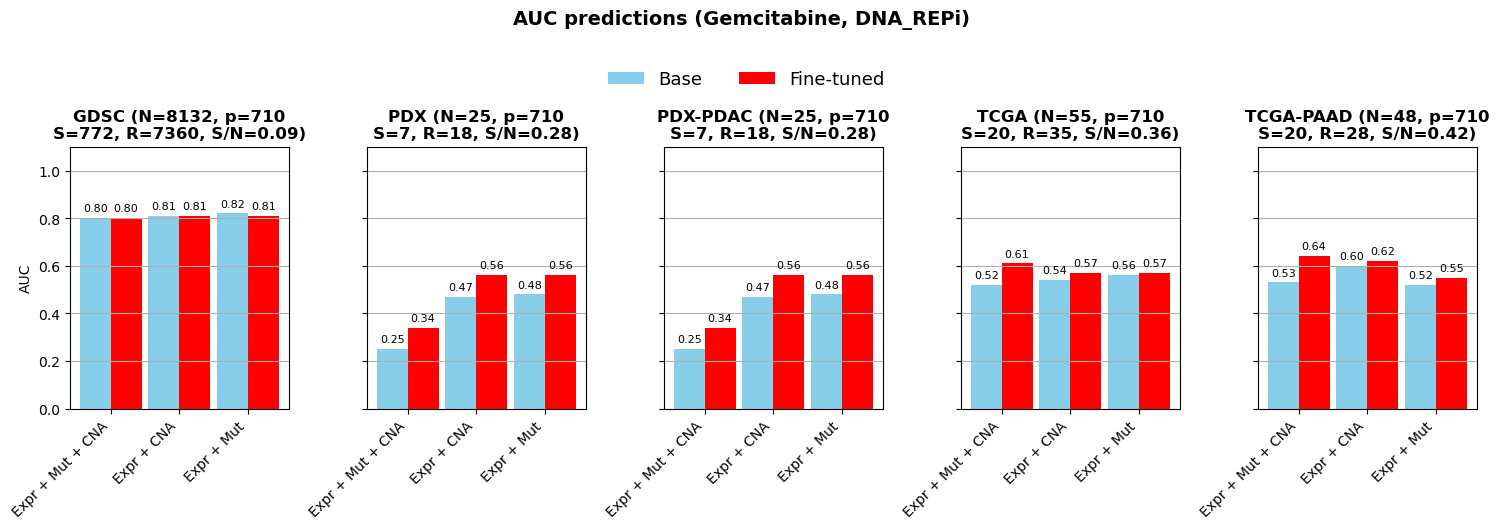

In [67]:
# plot AUC scores

df = auc_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.45
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

axes[0].set_ylabel('AUC')
fig.suptitle('AUC predictions (Gemcitabine, DNA_REPi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUC Plot (Gemcitabine, DNA_REPi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [68]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

aucpr_dataframe = all_dataframe[[f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUCPR (PDX, N={str(len(Ytsgemcitabine_pdx))})",
                               f"AUCPR (PDX-PDAC, N={str(len(Ytsgemcitabine_pdx_pdac))})",
                               f"AUCPR (TCGA, N={str(len(Ytsgemcitabine_tcga))})",
                               f"AUCPR (TCGA-PAAD, N={str(len(Ytsgemcitabine_tcga_paad))})"]]


aucpr_dataframe.rename(
    columns = {
        f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUCPR (PDX, N={str(len(Ytsgemcitabine_pdx))})": f"PDX (N={str(len(Ytsgemcitabine_pdx))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRgemcitabine["response"].value_counts()[1]) + ", R=" + str(PDXRgemcitabine["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRgemcitabine["response"].value_counts()[1]/sum(PDXRgemcitabine["response"].value_counts()), 2)) + ")",        
        f"AUCPR (PDX-PDAC, N={str(len(Ytsgemcitabine_pdx_pdac))})": f"PDX-PDAC (N={str(len(Ytsgemcitabine_pdx_pdac))}, p=" + str(PDXEgemcitabine.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "PDAC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "PDAC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "PDAC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "PDAC","response"].value_counts()), 2)) + ")",        
        f"AUCPR (TCGA, N={str(len(Ytsgemcitabine_tcga))})": f"TCGA (N={str(len(Ytsgemcitabine_tcga))}, p=" + str(PDXEgemcitabine.shape[1]) + "\nS=" + str(TCGARgemcitabine["response"].value_counts()[1]) + ", R=" + str(TCGARgemcitabine["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARgemcitabine["response"].value_counts()[1]/sum(TCGARgemcitabine["response"].value_counts()), 2)) + ")",        
        f"AUCPR (TCGA-PAAD, N={str(len(Ytsgemcitabine_tcga_paad))})": f"TCGA-PAAD (N={str(len(Ytsgemcitabine_tcga_paad))}, p=" + str(TCGAEgemcitabine.shape[1]) + "\nS=" + str(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()[1]) + ", R=" + str(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()[1]/sum(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
aucpr_dataframe

,"GDSC (N=8132, p=710\nS=772, R=7360, S/N=0.09)","PDX (N=25, p=710\nS=7, R=18, S/N=0.28)","PDX-PDAC (N=25, p=710\nS=7, R=18, S/N=0.28)","TCGA (N=55, p=710\nS=20, R=35, S/N=0.36)","TCGA-PAAD (N=48, p=710\nS=20, R=28, S/N=0.42)"
Data,,,,,
Expr + Mut + CNA,0.32,0.22,0.22,0.39,0.46
Expr + Mut + CNA (Fine-tuned),0.32,0.4,0.4,0.44,0.52
Expr + CNA,0.34,0.35,0.35,0.41,0.62
Expr + CNA (Fine-tuned),0.33,0.4,0.4,0.43,0.65
Expr + Mut,0.33,0.32,0.32,0.42,0.49
Expr + Mut (Fine-tuned),0.33,0.4,0.4,0.45,0.53


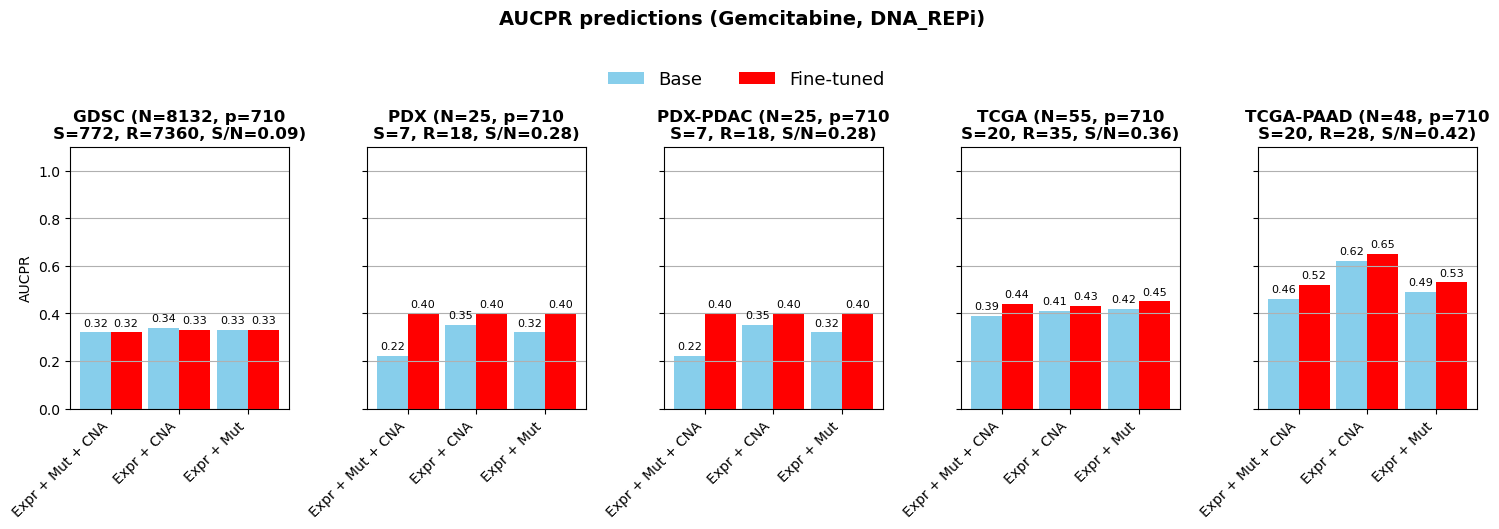

In [69]:
# plot AUCPR scores

df = aucpr_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.45
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

axes[0].set_ylabel('AUCPR')
fig.suptitle('AUCPR predictions (Gemcitabine, DNA_REPi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUCPR Plot (Gemcitabine, DNA_REPi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [70]:
# change directory

os.chdir(save_results_to)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Predictions/GDSC_PDX_TCGA_Fourth_Strategy


In [71]:
# save predictions

file = open('GDSC_PDX_TCGA_DNA_REPi_Gemcitabine_Predictions_Fourth_Strategy (Expression and Mutation).txt', 'w')
file.write(f"GDSC Training (EM) AUC (DNA_REPi): {round(AUCT,2)}\n")
file.write(f"GDSC Training (EM) AUCPR (DNA_REPi): {round(AUCTaucpr,2)}\n\n")

file.write(f"PDX Test (EM) AUC (Gemcitabine): {round(AUCTgemcitabine_pdx,2)}\n")
file.write(f"PDX Test (EM) AUCPR (Gemcitabine): {round(AUCTgemcitabine_pdx_aucpr,2)}\n\n")

file.write(f"PDX Test (EM) AUC (Gemcitabine, PDAC): {round(AUCTgemcitabine_pdx_pdac,2)}\n")
file.write(f"PDX Test (EM) AUCPR (Gemcitabine, PDAC): {round(AUCTgemcitabine_pdx_pdac_aucpr,2)}\n\n")

file.write(f"TCGA Test (EM) AUC (Gemcitabine): {round(AUCTgemcitabine_tcga,2)}\n")
file.write(f"TCGA Test (EM) AUCPR (Gemcitabine): {round(AUCTgemcitabine_tcga_aucpr,2)}\n\n")

file.write(f"TCGA Test (EM) AUC (Gemcitabine, PAAD): {round(AUCTgemcitabine_tcga_paad,2)}\n")
file.write(f"TCGA Test (EM) AUCPR (Gemcitabine, PAAD): {round(AUCTgemcitabine_tcga_paad_aucpr,2)}\n")

file.close()